# 1 Wstęp

## 1.1 Wybór DataSetu
### Baza danych, którą wybrałem, zawiera informacje o zawodnikach crossfit. Posiada około 400 tysięcy wierszy oraz 27 kolumn z różnymi danymi, opisowymi i numerycznymi. 
### Dodatkowo baza jest dość mocno 'popsuta', zawiera dużo pustych wartości oraz skrajnych błędnych danych.
## 1.2 Wybór pola do analizy
### Postanowiłem na podstawie analizowanych danych pozwolić klasyfikatorom decydować czy dana osoba jest kobietą czy mężczyzną. Procent poprawności zgadywania powinien być zadowalający, gdyż wyniki sportowe w konkurencjach siłowych dość mocno zależą od płci zawodnika.

# 2 Program do klasyfikacji danych
## Import paczek i załadowanie danych wejściowych

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("C:/infa/zajecia/4 semestr/io/projekt2/athletes.csv")
df2 = df.copy()

## 2.1 Pierwszy model preprocessingu
### W pierwszym podejściu, bardziej przetworzoną bazą danych, poza koniecznymi elementami, oczyszczam dane z wszystkich nieoczekiwanych wartości.
### 2.1.1 Usunięcie fałszywych danych:
#### - metodą 'z-scores' analizuję potrzebne mi kolumny
#### - następnie sprawdzając otrzymane wyniki, dostosowuje parametr który decyduje jakie dane są traktowane jako 'outliers' (skrajne)
#### - tak otrzymane dane usuwam, zastępując je wartościami NaN

In [21]:
age_z_scores =  np.abs((df.age - df.age.mean())/df.age.std(ddof=1))
height_z_scores =  np.abs((df.height - df.height.mean())/df.height.std(ddof=1))
weight_z_scores =  np.abs((df.weight - df.weight.mean())/df.weight.std(ddof=1))
candj_z_scores =  np.abs((df.candj - df.candj.mean())/df.candj.std(ddof=1))
snatch_z_scores =  np.abs((df.snatch - df.snatch.mean())/df.snatch.std(ddof=1))
deadlift_z_scores =  np.abs((df.deadlift - df.deadlift.mean())/df.deadlift.std(ddof=1))
backsq_z_scores =  np.abs((df.backsq - df.backsq.mean())/df.backsq.std(ddof=1))
pullups_z_scores =  np.abs((df.pullups - df.pullups.mean())/df.pullups.std(ddof=1))

age_outliers = df[age_z_scores > 4]
height_outliers = df[height_z_scores > 0.003]
weight_outliers = df[weight_z_scores > 2]
candj_outliers = df[candj_z_scores > 0.01]
snatch_outliers = df[snatch_z_scores > 0.01]
deadlift_outliers = df[deadlift_z_scores > 0.01]
backsq_outliers = df[backsq_z_scores > 0.01]
pullups_outliers = df[pullups_z_scores > 0.00447254]

print(age_outliers['age'])

df.loc[age_outliers.index, 'age'] = np.nan
df.loc[weight_outliers.index, 'weight'] = np.nan
df.loc[height_outliers.index, 'height'] = np.nan
df.loc[candj_outliers.index, 'candj'] = np.nan
df.loc[snatch_outliers.index, 'snatch'] = np.nan
df.loc[deadlift_outliers.index, 'deadlift'] = np.nan
df.loc[backsq_outliers.index, 'backsq'] = np.nan
df.loc[pullups_outliers.index, 'pullups'] = np.nan

4446      115.0
27115     125.0
358673    124.0
363267    125.0
364750    124.0
371122    123.0
382443     98.0
404768    124.0
Name: age, dtype: float64


#### Oto przykład usuniętych błędnych danych. Nie jest to wysoce prawdopodobne, aby zawodnicy mieli powyżej 100 lat.

### 2.1.2 Usunięcie pustych danych
#### - najpierw usuwam rekordy, które mają połowę pustych danych, taki wiersz możemy uznać za przypadkowy i niewartościowy
#### - następnie usuwam wszystkie niepotrzebne mi kolumny, a więc opisowe oraz takie, które nie wnoszą nic do mojej klasyfikacji
#### - dodatkowo usuwam wiersze, które w najważniejszym polu płci posiadają błąd lub są puste
#### - finalnie grupuje wszystkie potrzebne mi dane według płci oraz obliczam poszczególne średnie wartości 'mean'
#### - uzupełniam wszystkie puste wartości tak otrzymanymi średnimi, sprawdzając najpierw płeć sportowca

In [22]:
df = df.dropna(thresh=14)
df = df[(df['gender'] == 'Male') | (df['gender'] == 'Female')]
df.drop(['athlete_id', 'eat', 'train', 'background', 'experience', 'schedule', 'howlong', 'fran', 'helen', 'grace',	'filthy50',
         'fgonebad', 'run400', 'run5k', 'name', 'region', 'team', 'affiliate'], axis=1, inplace=True)

mean_age_by_gender = df.groupby('gender')['age'].mean()
df['age'] = df.groupby('gender')['age'].transform(lambda x: x.fillna(x.mean()))
mean_weight_by_gender = df.groupby('gender')['weight'].mean()
df['weight'] = df.groupby('gender')['weight'].transform(lambda x: x.fillna(x.mean()))
mean_height_by_gender = df.groupby('gender')['height'].mean()
df['height'] = df.groupby('gender')['height'].transform(lambda x: x.fillna(x.mean()))
mean_candj_by_gender = df.groupby('gender')['candj'].mean()
df['candj'] = df.groupby('gender')['candj'].transform(lambda x: x.fillna(x.mean()))
mean_snatch_by_gender = df.groupby('gender')['snatch'].mean()
df['snatch'] = df.groupby('gender')['snatch'].transform(lambda x: x.fillna(x.mean()))
mean_deadlift_by_gender = df.groupby('gender')['deadlift'].mean()
df['deadlift'] = df.groupby('gender')['deadlift'].transform(lambda x: x.fillna(x.mean()))
mean_backsq_by_gender = df.groupby('gender')['backsq'].mean()
df['backsq'] = df.groupby('gender')['backsq'].transform(lambda x: x.fillna(x.mean()))
mean_pullups_by_gender = df.groupby('gender')['pullups'].mean()
df['pullups'] = df.groupby('gender')['pullups'].transform(lambda x: x.fillna(x.mean()))

print(mean_deadlift_by_gender)

gender
Female    245.254366
Male      397.214158
Name: deadlift, dtype: float64


#### Oto przykład średnich wyników w martwym ciągu po uwzględieniu płci.
#### Baza danych jest kompletna i gotowa do analizy !

### 2.1.3 Klasyfikacja
#### Dzielę bazę na zbiór treningowy oraz testowy. Jako ostatni etap preprocessingu przepuszczam dane przez 'Scaler' i poddaje normalizacji.

In [23]:
(train_set, test_set) = train_test_split(df.values, train_size=0.7)
train_inputs = np.delete(train_set, 0, axis=1)
train_classes = train_set[:, 0]
test_inputs = np.delete(test_set, 0, axis=1)
test_classes = test_set[:, 0]

sc = MinMaxScaler()
train_inputs = sc.fit_transform(train_inputs)
test_inputs = sc.transform(test_inputs)

#### Wywołuje wszystkie potrzebne mi klasyfikatory do testowania, które uczę na zbiorze treningowym: 
#### - Drzewo decyzyjne (w wersji mniejszej z przyciętymi gałęziami i większej)
#### - Naiwny Bayes
#### - K-Najbliższych Sąsiadów dla k = 3,5 oraz 11
#### - Sieć neuronowa dla różnych topologii i konfiguracji uczenia

In [ ]:
dtc = tree.DecisionTreeClassifier()
dtc2 = tree.DecisionTreeClassifier(max_depth=2)
naive_bay = GaussianNB()
knn3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
mlp = MLPClassifier(hidden_layer_sizes=(2), activation='relu', max_iter=500, validation_fraction=0.1, early_stopping=True)
mlp2 = MLPClassifier(hidden_layer_sizes=(3), activation='tanh', max_iter=500, validation_fraction=0.1, early_stopping=True)
mlp3 = MLPClassifier(hidden_layer_sizes=(6, 3), activation='logistic', max_iter=500, validation_fraction=0.1, early_stopping=True)

dtc.fit(train_inputs, train_classes)
dtc2.fit(train_inputs, train_classes)
naive_bay.fit(train_inputs, train_classes)
knn3.fit(train_inputs, train_classes)
knn5.fit(train_inputs, train_classes)
knn11.fit(train_inputs, train_classes)
mlp.fit(train_inputs, train_classes)
mlp2.fit(train_inputs, train_classes)
mlp3.fit(train_inputs, train_classes)

#### Rysuję krzywe uczenia się sieci neuronowych, uwzględniając zbiór treningowy oraz walidacyjny:

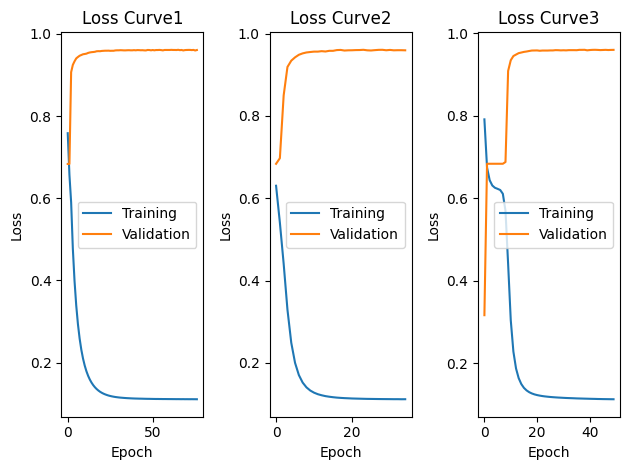

In [25]:
loss_curve = mlp.loss_curve_
val_loss = mlp.validation_scores_
loss_curve2 = mlp2.loss_curve_
val_loss2 = mlp2.validation_scores_
loss_curve3 = mlp3.loss_curve_
val_loss3 = mlp3.validation_scores_

plt.subplot(1, 3, 1)
plt.plot(loss_curve)
plt.plot(val_loss)
plt.title('Loss Curve1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='right')

plt.subplot(1, 3, 2)
plt.plot(loss_curve2)
plt.plot(val_loss2)
plt.title('Loss Curve2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='right')

plt.subplot(1, 3, 3)
plt.plot(loss_curve3)
plt.plot(val_loss3)
plt.title('Loss Curve3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='right')

plt.tight_layout()
plt.show()

#### Następnie testuję każdy z klasyfikatorów na zbiorze testowym i wyświetlam wyniki. Oto procenty ich poprawności.

In [26]:
dtc_accuracy = dtc.score(test_inputs, test_classes)
dtc2_accuracy = dtc2.score(test_inputs, test_classes)
naive_bay_accuracy = naive_bay.score(test_inputs, test_classes)
knn3_accuracy = knn3.score(test_inputs, test_classes)
knn5_accuracy = knn5.score(test_inputs, test_classes)
knn11_accuracy = knn11.score(test_inputs, test_classes)
mlp_accuracy = mlp.score(test_inputs, test_classes)
mlp2_accuracy = mlp2.score(test_inputs, test_classes)
mlp3_accuracy = mlp3.score(test_inputs, test_classes)
print("Procent poprawności dla DTC w większej wersji drzewa: ", dtc_accuracy, "\n")
print("Procent poprawności dla DTC w mniejsze wersji drzewa: ", dtc2_accuracy, "\n")
print("Procent poprawności dla Naive Bayes: ", naive_bay_accuracy, "\n")
print("Procent poprawności dla KNN przy k=3: ", knn3_accuracy, "\n")
print("Procent poprawności dla KNN przy k=5: ", knn5_accuracy, "\n")
print("Procent poprawności dla KNN przy k=11: ", knn11_accuracy, "\n")
print("Procent poprawności dla MLP przy 2 neuronach w warstwie: ", mlp_accuracy, "\n")
print("Procent poprawności dla MLP przy 3 neuronach w warstwie: ", mlp2_accuracy, "\n")
print("Procent poprawności dla MLP przy 2 warstwach z (6, 3) neuronami: ", mlp3_accuracy, "\n")

Procent poprawności dla DTC w większej wersji drzewa:  0.975808521560575 

Procent poprawności dla DTC w mniejsze wersji drzewa:  0.9445264373716632 

Procent poprawności dla Naive Bayes:  0.945424794661191 

Procent poprawności dla KNN przy k=3:  0.9617556468172485 

Procent poprawności dla KNN przy k=5:  0.9637448665297741 

Procent poprawności dla KNN przy k=11:  0.9642902977412731 

Procent poprawności dla MLP przy 2 neuronach w warstwie:  0.9594135010266941 

Procent poprawności dla MLP przy 3 neuronach w warstwie:  0.9583547227926078 

Procent poprawności dla MLP przy 2 warstwach z (6, 3) neuronami:  0.9586755646817249 



#### Jak widać najlepszy wynik wyniósł 97,5 %, co wydaje się całkiem dobrym rezultatem. Co ciekawe, najlepszy oraz najgorszy procent poprawności przypada Drzewom Decyzyjnym, odpowiednio większemu oraz temu z przyciętymi gałęziami.

#### Na koniec prezentuję jeszcze macierze błedów dla wszystkich klasyfikatorów.

In [27]:
dtc_y_pred = dtc.predict(test_inputs)
dtc2_y_pred = dtc2.predict(test_inputs)
naive_bay_y_pred = naive_bay.predict(test_inputs)
knn3_y_pred = knn3.predict(test_inputs)
knn5_y_pred = knn5.predict(test_inputs)
knn11_y_pred = knn11.predict(test_inputs)
mlp_y_pred = mlp.predict(test_inputs)
mlp2_y_pred = mlp2.predict(test_inputs)
mlp3_y_pred = mlp3.predict(test_inputs)
print("Macierz błędów dla DTC w większej wersji drzewa: \n", metrics.confusion_matrix(test_classes, dtc_y_pred))
print("Macierz błędów dla DTC w mniejsze wersji drzewa: \n", metrics.confusion_matrix(test_classes, dtc2_y_pred))
print("Macierz błędów dla Naive Bayes: \n", metrics.confusion_matrix(test_classes, naive_bay_y_pred))
print("Macierz błędów dla KNN przy k=3: \n", metrics.confusion_matrix(test_classes, knn3_y_pred))
print("Macierz błędów dla KNN przy k=5: \n", metrics.confusion_matrix(test_classes, knn5_y_pred))
print("Macierz błędów dla KNN przy k=11: \n", metrics.confusion_matrix(test_classes, knn11_y_pred))
print("Macierz błędów dla MLP przy 2 neuronach w warstwie: \n", metrics.confusion_matrix(test_classes, mlp_y_pred))
print("Macierz błędow dla MLP przy 3 neuronach w warstwie: \n", metrics.confusion_matrix(test_classes, mlp2_y_pred))
print("Macierz błędów dla MLP przy 2 warstwach z (6, 3) neuronami: \n", metrics.confusion_matrix(test_classes, mlp3_y_pred))

Macierz błędów dla DTC w większej wersji drzewa: 
 [[ 9468   369]
 [  385 20946]]
Macierz błędów dla DTC w mniejsze wersji drzewa: 
 [[ 8716  1121]
 [  608 20723]]
Macierz błędów dla Naive Bayes: 
 [[ 9533   304]
 [ 1397 19934]]
Macierz błędów dla KNN przy k=3: 
 [[ 9343   494]
 [  698 20633]]
Macierz błędów dla KNN przy k=5: 
 [[ 9375   462]
 [  668 20663]]
Macierz błędów dla KNN przy k=11: 
 [[ 9395   442]
 [  671 20660]]
Macierz błędów dla MLP przy 2 neuronach w warstwie: 
 [[ 9253   584]
 [  681 20650]]
Macierz błędow dla MLP przy 3 neuronach w warstwie: 
 [[ 9219   618]
 [  680 20651]]
Macierz błędów dla MLP przy 2 warstwach z (6, 3) neuronami: 
 [[ 9274   563]
 [  725 20606]]


## 2.2 Drugi model preprocessingu
### 2.2.1 Wstępna obróbka danych
#### W drugim podejściu, mniej przetworzonym, wykonuje tylko konieczne kroki. Pomijam usuwanie skrajnych wartości. W miejsce pustych danych nie wstawiam grupowanych średnich, a jedynie ich wartości dla całej kolumny, co może w znacznym stopniu wpłynąć na analizę wyników. Dodatkowo pomijam skalowanie wartości.

In [28]:
df2 = df2.dropna(thresh=14)
df2 = df2[(df2['gender'] == 'Male') | (df2['gender'] == 'Female')]
df2.drop(['athlete_id', 'eat', 'train', 'background', 'experience', 'schedule', 'howlong', 'fran', 'helen', 'grace', 'filthy50',
         'fgonebad', 'run400', 'run5k', 'name', 'region', 'team', 'affiliate'], axis=1, inplace=True)

mean_age = df2['age'].mean()
mean_weight = df2['weight'].mean()
mean_height = df2['height'].mean()
mean_candj = df2['candj'].mean()
mean_snatch = df2['snatch'].mean()
mean_deadlift = df2['deadlift'].mean()
mean_backsq = df2['backsq'].mean()
mean_pullups = df2['pullups'].mean()

df2['age'] = df2['age'].fillna(mean_age)
df2['weight'] = df2['weight'].fillna(mean_weight)
df2['height'] = df2['height'].fillna(mean_height)
df2['candj'] = df2['candj'].fillna(mean_candj)
df2['snatch'] = df2['snatch'].fillna(mean_snatch)
df2['deadlift'] = df2['deadlift'].fillna(mean_deadlift)
df2['backsq'] = df2['backsq'].fillna(mean_backsq)
df2['pullups'] = df2['pullups'].fillna(mean_pullups)

### 2.2.2 Klasyfikacja
#### Jak poprzednio, dzielę zbiory na treningowy i testowy oraz wywołuje klasyfikatory z tymi samymi parametrami co w 1 podejścu.

In [29]:
(train_set, test_set) = train_test_split(df2.values, train_size=0.7)
train_inputs = np.delete(train_set, 0, axis=1)
train_classes = train_set[:, 0]
test_inputs = np.delete(test_set, 0, axis=1)
test_classes = test_set[:, 0]

dtc = tree.DecisionTreeClassifier()
dtc2 = tree.DecisionTreeClassifier(max_depth=2)
naive_bay = GaussianNB()
knn3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
mlp = MLPClassifier(hidden_layer_sizes=(2), activation='relu', max_iter=500, validation_fraction=0.1, early_stopping=True)
mlp2 = MLPClassifier(hidden_layer_sizes=(3), activation='tanh', max_iter=500, validation_fraction=0.1, early_stopping=True)
mlp3 = MLPClassifier(hidden_layer_sizes=(6, 3), activation='logistic', max_iter=500, validation_fraction=0.1, early_stopping=True)

#### Nauczam klasyfikatory na zbiorze treningowym i rysuję krzywe uczenia dla sieci neuronowych.

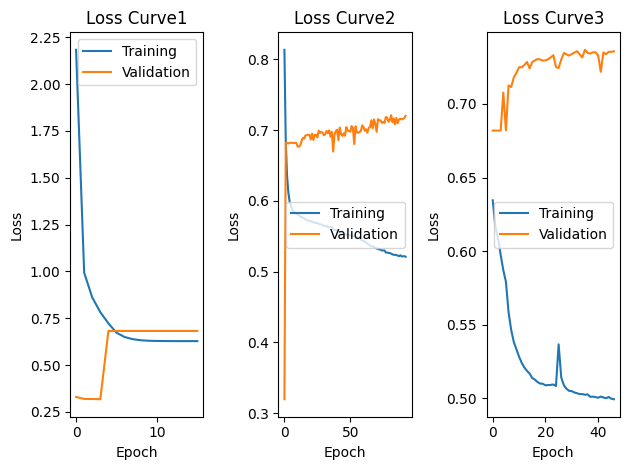

In [30]:
dtc.fit(train_inputs, train_classes)
dtc2.fit(train_inputs, train_classes)
naive_bay.fit(train_inputs, train_classes)
knn3.fit(train_inputs, train_classes)
knn5.fit(train_inputs, train_classes)
knn11.fit(train_inputs, train_classes)
mlp.fit(train_inputs, train_classes)
mlp2.fit(train_inputs, train_classes)
mlp3.fit(train_inputs, train_classes)

loss_curve = mlp.loss_curve_
val_loss = mlp.validation_scores_
loss_curve2 = mlp2.loss_curve_
val_loss2 = mlp2.validation_scores_
loss_curve3 = mlp3.loss_curve_
val_loss3 = mlp3.validation_scores_

plt.subplot(1, 3, 1)
plt.plot(loss_curve)
plt.plot(val_loss)
plt.title('Loss Curve1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(loss_curve2)
plt.plot(val_loss2)
plt.title('Loss Curve2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='right')

plt.subplot(1, 3, 3)
plt.plot(loss_curve3)
plt.plot(val_loss3)
plt.title('Loss Curve3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='right')

plt.tight_layout()
plt.show()

#### Jak widać krzywe dość mocno różnią się od tych zaprezentowanych w pierwszym podejściu. W kolejnym kroku sprawdzimy procenty poprawności zgadywania płci.

In [31]:
dtc_accuracy = dtc.score(test_inputs, test_classes)
dtc2_accuracy = dtc2.score(test_inputs, test_classes)
naive_bay_accuracy = naive_bay.score(test_inputs, test_classes)
knn3_accuracy = knn3.score(test_inputs, test_classes)
knn5_accuracy = knn5.score(test_inputs, test_classes)
knn11_accuracy = knn11.score(test_inputs, test_classes)
mlp_accuracy = mlp.score(test_inputs, test_classes)
mlp2_accuracy = mlp2.score(test_inputs, test_classes)
mlp3_accuracy = mlp3.score(test_inputs, test_classes)
print("Procent poprawności dla DTC w większej wersji drzewa: ", dtc_accuracy, "\n")
print("Procent poprawności dla DTC w mniejsze wersji drzewa: ", dtc2_accuracy, "\n")
print("Procent poprawności dla Naive Bayes: ", naive_bay_accuracy, "\n")
print("Procent poprawności dla KNN przy k=3: ", knn3_accuracy, "\n")
print("Procent poprawności dla KNN przy k=5: ", knn5_accuracy, "\n")
print("Procent poprawności dla KNN przy k=11: ", knn11_accuracy, "\n")
print("Procent poprawności dla MLP przy 2 neuronach w warstwie: ", mlp_accuracy, "\n")
print("Procent poprawności dla MLP przy 3 neuronach w warstwie: ", mlp2_accuracy, "\n")
print("Procent poprawności dla MLP przy 2 warstwach z (6, 3) neuronami: ", mlp3_accuracy, "\n")

Procent poprawności dla DTC w większej wersji drzewa:  0.9101568689589605 

Procent poprawności dla DTC w mniejsze wersji drzewa:  0.885184598320393 

Procent poprawności dla Naive Bayes:  0.3169386784978609 

Procent poprawności dla KNN przy k=3:  0.9170971319917605 

Procent poprawności dla KNN przy k=5:  0.9213436856282681 

Procent poprawności dla KNN przy k=11:  0.9240057043257803 

Procent poprawności dla MLP przy 2 neuronach w warstwie:  0.6832197749960387 

Procent poprawności dla MLP przy 3 neuronach w warstwie:  0.7267627951196324 

Procent poprawności dla MLP przy 2 warstwach z (6, 3) neuronami:  0.7358263349706861 



#### Jak mogliśmy się spodziewać wyniki są o wiele słabsze. Naiwny Bayes wypadł najgorzej, 30 % poprawność nie jest zbyt zadowalająca.
#### Na koniec macierze błędów.

In [32]:
dtc_y_pred = dtc.predict(test_inputs)
dtc2_y_pred = dtc2.predict(test_inputs)
naive_bay_y_pred = naive_bay.predict(test_inputs)
knn3_y_pred = knn3.predict(test_inputs)
knn5_y_pred = knn5.predict(test_inputs)
knn11_y_pred = knn11.predict(test_inputs)
mlp_y_pred = mlp.predict(test_inputs)
mlp2_y_pred = mlp2.predict(test_inputs)
mlp3_y_pred = mlp3.predict(test_inputs)
print("Macierz błędów dla DTC w większej wersji drzewa: \n", metrics.confusion_matrix(test_classes, dtc_y_pred))
print("Macierz błędów dla DTC w mniejsze wersji drzewa: \n", metrics.confusion_matrix(test_classes, dtc2_y_pred))
print("Macierz błędów dla Naive Bayes: \n", metrics.confusion_matrix(test_classes, naive_bay_y_pred))
print("Macierz błędów dla KNN przy k=3: \n", metrics.confusion_matrix(test_classes, knn3_y_pred))
print("Macierz błędów dla KNN przy k=5: \n", metrics.confusion_matrix(test_classes, knn5_y_pred))
print("Macierz błędów dla KNN przy k=11: \n", metrics.confusion_matrix(test_classes, knn11_y_pred))
print("Macierz błędów dla MLP przy 2 neuronach w warstwie: \n", metrics.confusion_matrix(test_classes, mlp_y_pred))
print("Macierz błędow dla MLP przy 3 neuronach w warstwie: \n", metrics.confusion_matrix(test_classes, mlp2_y_pred))
print("Macierz błędów dla MLP przy 2 warstwach z (6, 3) neuronami: \n", metrics.confusion_matrix(test_classes, mlp3_y_pred))

Macierz błędów dla DTC w większej wersji drzewa: 
 [[ 8620  1376]
 [ 1459 20100]]
Macierz błędów dla DTC w mniejsze wersji drzewa: 
 [[ 7787  2209]
 [ 1414 20145]]
Macierz błędów dla Naive Bayes: 
 [[ 9995     1]
 [21553     6]]
Macierz błędów dla KNN przy k=3: 
 [[ 8834  1162]
 [ 1454 20105]]
Macierz błędów dla KNN przy k=5: 
 [[ 8902  1094]
 [ 1388 20171]]
Macierz błędów dla KNN przy k=11: 
 [[ 8949  1047]
 [ 1351 20208]]
Macierz błędów dla MLP przy 2 neuronach w warstwie: 
 [[    0  9996]
 [    0 21559]]
Macierz błędow dla MLP przy 3 neuronach w warstwie: 
 [[ 2395  7601]
 [ 1021 20538]]
Macierz błędów dla MLP przy 2 warstwach z (6, 3) neuronami: 
 [[ 2397  7599]
 [  737 20822]]


# 3 Podsumowanie
## Jak widać w powyższych doświadczeniach, preprocessing jest nieodłącznym i kluczowym elementem analizy bazy danych. Zbliżone do siebie około 96 % wyniki przy pierwszym modelu. Dość mocno rozrzucone, od 90 do tylko 30 procent, wyniki poprawności drugiego modelu. Poddając analizie poszczególne klasyfikatory, bardzo dobrze w obu przypadkach wypadła metoda K-najbliższych sąsiadów oraz Drzewo Decyzyjne o większej złożoności. Sieci neuronowe nieco gorzej, na co dość duży wpływ mogły mieć testowane konfiguracje parametrów. Naiwny Bayes wydaje się zamykać stawkę, choć, przy idealnie oczyszczonych danych, radzi sobie również nienagannie.

## Bibliografia:
### https://scikit-learn.org/stable/modules/classes.html
### https://www.kaggle.com/datasets
### https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
### https://matplotlib.org/stable/index.html